In [2]:
import os  
import numpy as np
from scipy import *
from numpy import dot, multiply, diag, power, pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv,norm
from scipy.linalg import svd, svdvals 
import scipy.io as sio  
import re  
import warnings
warnings.filterwarnings("ignore")

import torch 
from torch.autograd import Variable
from torch.optim import Adam, SGD   
import torch.optim as optim
import matplotlib.pyplot as plt 

from utility import *
from model import *

In [3]:
# parameters
savename = 'FGSM_regu_test'  
n_class =87
dim_input = 1
# parameters for CNN 
patience = 30  
gamma = 0.1
batch_size =70
display_step = 100  
num_bus =68 
learning_rate = 0.01               
rootPath =  './data'
trainName = 'train_data.mat'  
testName = 'testing_sigPQ_perturb_1' 
scenario = 1 # choose 1 or 2 denoting the two kinds of testing data in the corresponding scenario 
model_dir  = './saved_model' 
epsilon = 0.005
k = 7
alpha = 0.01 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
weight_decay = 5e-5
epochs =800  
dim_input = 1 
dim_hidden = [4,8,8,8]
nclass = 87
seed = 1 
early_stop = False
lam  = 0.1  

In [4]:
# load data
data = sio.loadmat(os.path.join(rootPath, trainName))
linedata, Y,  line_neib = loadline(rootPath  ) 
Y_ri = np.r_[np.c_[Y.real, -Y.imag], np.c_[ Y.imag, Y.real ]].T 
w = choose_w(linedata,2)  
train_x,    train_labels, train_num  = load_all_data_VI(w,rootPath, trainName ) 
cur_up_limit, cur_down_limit = current_dist(rootPath) 
vol_up_limit, vol_down_limit = vol_dist(rootPath) 
up_limit = epsilon * np.r_[vol_up_limit, cur_up_limit]
down_limit = epsilon *np.r_[vol_down_limit, cur_down_limit]
up_limit = convert_shape(up_limit, batch_size)
down_limit = convert_shape(down_limit, batch_size)

In [5]:
def main(seed, dim_input, dim_hidden, up_limit, down_limit, batch_size, step_size, k):
    np.random.seed( seed)
    torch.manual_seed( seed) 
    
    model = Net(dim_input, dim_hidden, nclass) 
    model.apply(weights_init) 
    model.train()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    criterion = CrossEntropyLoss()   
    pre_robust_acc = 0. 
    x_train, y_train = Variable(train_x)  , Variable(train_labels) 
    train_best = float('Inf') 
    train_loss_list= [] 
    for epoch in range( epochs):  
        train_loss = 0
        train_acc = 0
        train_n = 0  
        for i in range(int(train_x.shape[0] / batch_size)):
            id_train = np.random.choice(train_x.shape[0], batch_size, replace= False) 
            model.eval()
            batch_size, _, size_U, _ = x_train[id_train].shape 
            delta = torch.randn((batch_size, 1, 2*size_U, 1)).detach()
            delta = torch.min(torch.max(delta,   down_limit),   up_limit) 
            delta.requires_grad_() 
            delta_U = delta[:, 0, :size_U, 0]
            delta_I = delta[:, 0, size_U:,0]  
            output = model(x_train[id_train] +    delta[:, :, :size_U, :] )  
            loss = F.cross_entropy(output, y_train[id_train], size_average = False )\
            - gamma*torch.nn.functional.l1_loss( (torch.matmul( delta_U , torch.FloatTensor(Y_ri))   ), (delta_I), size_average = False)
            loss.backward()
            grad = delta.grad.detach()
            delta = delta.detach() + step_size * torch.sign(grad.detach()) 
            delta = torch.min(torch.max(delta,   down_limit),   up_limit)  
            model.train() 
            x_adv = x_train[id_train].detach()  + delta[:, :, :size_U, :].detach()
            output = model(x_adv)
            loss = criterion(output, y_train[id_train])
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            train_loss += loss.item()  #* y_train[id_train].size(0)
            train_acc  = (output.max(1)[1] == y_train[id_train]).sum().item() *100/np.shape(id_train)[0]  
            train_n += y_train[id_train].size(0)
            if epoch%5 == 0: 
                print('Training Epoch: {}, [{}/{}, {:.0f}%], loss is {:.6f}'\
                      .format(epoch  , i * batch_size, train_x.shape[0],  train_acc  , train_loss  )) 
                if train_loss < train_best:
                    print('Best Epoch is', epoch)
                    train_best = train_loss 
                    torch.save(model.state_dict(), os.path.join(model_dir, savename+'.pt'))
                    torch.save(optimizer.state_dict(), os.path.join(model_dir, savename+'.tar')) 
            train_loss_list.append(loss.item())  
        if not early_stop:
            best_state_dict = model.state_dict()    
    plt.plot(train_loss_list)
    return train_loss_list , train_best 
 

Training Epoch: 0, [0/560, 0%], loss is 4.599880
Best Epoch is 0
Training Epoch: 0, [70/560, 3%], loss is 9.090025
Training Epoch: 0, [140/560, 4%], loss is 13.526078
Training Epoch: 0, [210/560, 3%], loss is 17.816147
Training Epoch: 0, [280/560, 7%], loss is 22.081490
Training Epoch: 0, [350/560, 3%], loss is 26.319813
Training Epoch: 0, [420/560, 3%], loss is 30.383198
Training Epoch: 0, [490/560, 10%], loss is 34.372400
Training Epoch: 5, [0/560, 34%], loss is 2.447065
Best Epoch is 5
Training Epoch: 5, [70/560, 41%], loss is 4.734198
Training Epoch: 5, [140/560, 37%], loss is 6.964426
Training Epoch: 5, [210/560, 47%], loss is 9.141148
Training Epoch: 5, [280/560, 37%], loss is 11.393148
Training Epoch: 5, [350/560, 57%], loss is 13.267356
Training Epoch: 5, [420/560, 47%], loss is 15.313982
Training Epoch: 5, [490/560, 41%], loss is 17.432594
Training Epoch: 10, [0/560, 50%], loss is 1.489978
Best Epoch is 10
Training Epoch: 10, [70/560, 56%], loss is 2.823025
Training Epoch: 10,

Training Epoch: 100, [0/560, 91%], loss is 0.247265
Training Epoch: 100, [70/560, 89%], loss is 0.564861
Training Epoch: 100, [140/560, 89%], loss is 0.835068
Training Epoch: 100, [210/560, 87%], loss is 1.209579
Training Epoch: 100, [280/560, 80%], loss is 1.624558
Training Epoch: 100, [350/560, 93%], loss is 1.881071
Training Epoch: 100, [420/560, 86%], loss is 2.211329
Training Epoch: 100, [490/560, 91%], loss is 2.478014
Training Epoch: 105, [0/560, 86%], loss is 0.713690
Training Epoch: 105, [70/560, 84%], loss is 1.084600
Training Epoch: 105, [140/560, 87%], loss is 1.463745
Training Epoch: 105, [210/560, 80%], loss is 2.087129
Training Epoch: 105, [280/560, 89%], loss is 2.435305
Training Epoch: 105, [350/560, 89%], loss is 2.793610
Training Epoch: 105, [420/560, 80%], loss is 3.228585
Training Epoch: 105, [490/560, 89%], loss is 3.600450
Training Epoch: 110, [0/560, 86%], loss is 0.388014
Training Epoch: 110, [70/560, 89%], loss is 0.648177
Training Epoch: 110, [140/560, 90%], 

Training Epoch: 200, [0/560, 93%], loss is 0.123837
Training Epoch: 200, [70/560, 90%], loss is 0.289700
Training Epoch: 200, [140/560, 93%], loss is 0.481654
Training Epoch: 200, [210/560, 97%], loss is 0.621277
Training Epoch: 200, [280/560, 93%], loss is 0.845089
Training Epoch: 200, [350/560, 91%], loss is 1.036086
Training Epoch: 200, [420/560, 97%], loss is 1.182209
Training Epoch: 200, [490/560, 94%], loss is 1.353374
Training Epoch: 205, [0/560, 84%], loss is 0.328061
Training Epoch: 205, [70/560, 87%], loss is 0.639518
Training Epoch: 205, [140/560, 93%], loss is 0.849810
Training Epoch: 205, [210/560, 91%], loss is 1.092057
Training Epoch: 205, [280/560, 94%], loss is 1.294851
Training Epoch: 205, [350/560, 91%], loss is 1.612081
Training Epoch: 205, [420/560, 90%], loss is 1.997121
Training Epoch: 205, [490/560, 86%], loss is 2.399600
Training Epoch: 210, [0/560, 94%], loss is 0.221358
Training Epoch: 210, [70/560, 91%], loss is 0.516945
Training Epoch: 210, [140/560, 90%], 

Training Epoch: 300, [0/560, 90%], loss is 0.246543
Training Epoch: 300, [70/560, 86%], loss is 0.594448
Training Epoch: 300, [140/560, 87%], loss is 0.880366
Training Epoch: 300, [210/560, 90%], loss is 1.099181
Training Epoch: 300, [280/560, 99%], loss is 1.191623
Training Epoch: 300, [350/560, 94%], loss is 1.357487
Training Epoch: 300, [420/560, 93%], loss is 1.568408
Training Epoch: 300, [490/560, 99%], loss is 1.691181
Training Epoch: 305, [0/560, 87%], loss is 0.229496
Training Epoch: 305, [70/560, 93%], loss is 0.427428
Training Epoch: 305, [140/560, 89%], loss is 0.680836
Training Epoch: 305, [210/560, 90%], loss is 0.917776
Training Epoch: 305, [280/560, 97%], loss is 1.029827
Training Epoch: 305, [350/560, 93%], loss is 1.210706
Training Epoch: 305, [420/560, 91%], loss is 1.447410
Training Epoch: 305, [490/560, 89%], loss is 1.639226
Training Epoch: 310, [0/560, 91%], loss is 0.246420
Training Epoch: 310, [70/560, 97%], loss is 0.372177
Training Epoch: 310, [140/560, 96%], 

Training Epoch: 400, [0/560, 94%], loss is 0.140933
Training Epoch: 400, [70/560, 93%], loss is 0.262699
Training Epoch: 400, [140/560, 90%], loss is 0.474874
Training Epoch: 400, [210/560, 94%], loss is 0.643344
Training Epoch: 400, [280/560, 97%], loss is 0.761692
Training Epoch: 400, [350/560, 97%], loss is 0.970055
Training Epoch: 400, [420/560, 93%], loss is 1.144382
Training Epoch: 400, [490/560, 93%], loss is 1.329769
Training Epoch: 405, [0/560, 93%], loss is 0.135032
Training Epoch: 405, [70/560, 91%], loss is 0.392291
Training Epoch: 405, [140/560, 90%], loss is 0.765467
Training Epoch: 405, [210/560, 94%], loss is 0.882062
Training Epoch: 405, [280/560, 99%], loss is 1.010079
Training Epoch: 405, [350/560, 81%], loss is 1.622313
Training Epoch: 405, [420/560, 93%], loss is 1.794975
Training Epoch: 405, [490/560, 93%], loss is 1.957394
Training Epoch: 410, [0/560, 86%], loss is 0.377354
Training Epoch: 410, [70/560, 91%], loss is 0.601555
Training Epoch: 410, [140/560, 97%], 

Training Epoch: 500, [0/560, 84%], loss is 0.399232
Training Epoch: 500, [70/560, 94%], loss is 0.530797
Training Epoch: 500, [140/560, 91%], loss is 0.887626
Training Epoch: 500, [210/560, 90%], loss is 1.182354
Training Epoch: 500, [280/560, 93%], loss is 1.399531
Training Epoch: 500, [350/560, 94%], loss is 1.565223
Training Epoch: 500, [420/560, 91%], loss is 1.780616
Training Epoch: 500, [490/560, 90%], loss is 2.178031
Training Epoch: 505, [0/560, 90%], loss is 0.247169
Training Epoch: 505, [70/560, 91%], loss is 0.556859
Training Epoch: 505, [140/560, 94%], loss is 0.683827
Training Epoch: 505, [210/560, 97%], loss is 0.810587
Training Epoch: 505, [280/560, 94%], loss is 0.957129
Training Epoch: 505, [350/560, 97%], loss is 1.102115
Training Epoch: 505, [420/560, 89%], loss is 1.362432
Training Epoch: 505, [490/560, 96%], loss is 1.456164
Training Epoch: 510, [0/560, 96%], loss is 0.109780
Training Epoch: 510, [70/560, 94%], loss is 0.278044
Training Epoch: 510, [140/560, 93%], 

Training Epoch: 600, [0/560, 96%], loss is 0.121078
Training Epoch: 600, [70/560, 94%], loss is 0.326495
Training Epoch: 600, [140/560, 93%], loss is 0.453316
Training Epoch: 600, [210/560, 90%], loss is 0.707260
Training Epoch: 600, [280/560, 93%], loss is 0.878310
Training Epoch: 600, [350/560, 87%], loss is 1.113825
Training Epoch: 600, [420/560, 96%], loss is 1.304042
Training Epoch: 600, [490/560, 93%], loss is 1.559476
Training Epoch: 605, [0/560, 91%], loss is 0.207173
Training Epoch: 605, [70/560, 90%], loss is 0.423522
Training Epoch: 605, [140/560, 90%], loss is 0.660945
Training Epoch: 605, [210/560, 90%], loss is 0.861916
Training Epoch: 605, [280/560, 91%], loss is 1.035380
Training Epoch: 605, [350/560, 93%], loss is 1.205006
Training Epoch: 605, [420/560, 96%], loss is 1.304453
Training Epoch: 605, [490/560, 93%], loss is 1.517797
Training Epoch: 610, [0/560, 99%], loss is 0.048408
Best Epoch is 610
Training Epoch: 610, [70/560, 91%], loss is 0.227070
Training Epoch: 610

Training Epoch: 700, [0/560, 93%], loss is 0.153761
Training Epoch: 700, [70/560, 99%], loss is 0.241701
Training Epoch: 700, [140/560, 94%], loss is 0.372997
Training Epoch: 700, [210/560, 89%], loss is 0.600308
Training Epoch: 700, [280/560, 97%], loss is 0.696394
Training Epoch: 700, [350/560, 99%], loss is 0.805255
Training Epoch: 700, [420/560, 91%], loss is 0.956070
Training Epoch: 700, [490/560, 97%], loss is 1.045164
Training Epoch: 705, [0/560, 91%], loss is 0.197620
Training Epoch: 705, [70/560, 96%], loss is 0.319314
Training Epoch: 705, [140/560, 96%], loss is 0.470642
Training Epoch: 705, [210/560, 93%], loss is 0.693721
Training Epoch: 705, [280/560, 97%], loss is 0.816819
Training Epoch: 705, [350/560, 93%], loss is 1.026928
Training Epoch: 705, [420/560, 97%], loss is 1.120232
Training Epoch: 705, [490/560, 96%], loss is 1.250354
Training Epoch: 710, [0/560, 97%], loss is 0.112728
Training Epoch: 710, [70/560, 97%], loss is 0.188814
Training Epoch: 710, [140/560, 91%], 

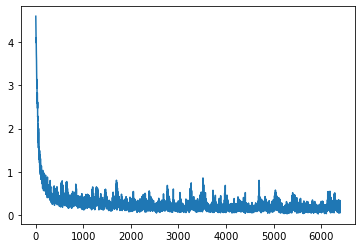

In [6]:
if __name__ == "__main__":
    train_loss, train_best  = main(seed, dim_input, dim_hidden, up_limit, down_limit, batch_size, alpha, k)

In [8]:
# Test the performance
model_test = Net(dim_input, dim_hidden, nclass)
model_test.load_state_dict(torch.load( os.path.join(model_dir,  savename + '.pt')))
model_test.float()
model_test.eval()
acc_list = scenario_test(scenario, w, rootPath, model_test)
print(acc_list)


testing_sigPQ_perturb_1
Test set results: loss= 0.0893 accuracy= 96.9643 1-hop accuracy = 0.9982
testing_sigPQ_perturb_1.5
Test set results: loss= 0.3887 accuracy= 88.5714 1-hop accuracy = 0.9643
testing_sigPQ_perturb_2
Test set results: loss= 1.0563 accuracy= 78.7500 1-hop accuracy = 0.9196
testing_sigPQ_perturb_3
Test set results: loss= 2.8310 accuracy= 64.6429 1-hop accuracy = 0.8375
[[96.96 88.57 78.75 64.64]]
